In [1]:
!python --version

Python 3.13.7


In [2]:
from google import genai
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
client = genai.Client(api_key=GEMINI_API_KEY)

In [3]:
import json

with open(r"C:\Auto\HCI-Summarize_agent\data\query\week3_09-23_to_09-29.json", "r", encoding="utf-8") as f:
    news = json.load(f)

print(list(news.keys()))

['Nvidia', 'AMD', 'Intel']


In [4]:
for chipmaker, data in news.items():
    print(f"Processing news for {chipmaker}")
    dict_cnt = {}

    for article in data:
        ts = article['timestamp']

        if ts not in dict_cnt:
            dict_cnt[ts] = {'cnt': 0, 'null': 0}

        dict_cnt[ts]['cnt'] += 1

        if article['content'] is None:
            dict_cnt[ts]['null'] += 1

    for k, v in dict_cnt.items():
        print(f"Date: {k}, Total Articles: {v['cnt']}, Null Articles: {v['null']}")

    print()

Processing news for Nvidia
Date: 2025-09-28, Total Articles: 32, Null Articles: 11
Date: 2025-09-27, Total Articles: 24, Null Articles: 4
Date: 2025-09-23, Total Articles: 24, Null Articles: 1
Date: 2025-09-24, Total Articles: 20, Null Articles: 3
Date: 2025-09-25, Total Articles: 20, Null Articles: 1
Date: 2025-09-26, Total Articles: 20, Null Articles: 4
Date: 2025-09-29, Total Articles: 20, Null Articles: 3

Processing news for AMD
Date: 2025-09-28, Total Articles: 20, Null Articles: 8
Date: 2025-09-27, Total Articles: 23, Null Articles: 1
Date: 2025-09-26, Total Articles: 22, Null Articles: 1
Date: 2025-09-23, Total Articles: 30, Null Articles: 2
Date: 2025-09-24, Total Articles: 20, Null Articles: 5
Date: 2025-09-25, Total Articles: 20, Null Articles: 3
Date: 2025-09-29, Total Articles: 20, Null Articles: 5

Processing news for Intel
Date: 2025-09-28, Total Articles: 28, Null Articles: 8
Date: 2025-09-27, Total Articles: 24, Null Articles: 3
Date: 2025-09-23, Total Articles: 29, Nu

In [5]:
import random

for chipmaker, data in news.items():
    print(f"Processing {chipmaker}")

    grouped = {}
    for article in data:
        ts = article['timestamp']
        grouped.setdefault(ts, []).append(article)

    new_articles = []

    for ts, articles in grouped.items():
        null_articles = [a for a in articles if a['content'] is None]
        valid_articles = [a for a in articles if a['content'] is not None]

        total_count = len(articles)

        if total_count > 10:
            keep_count = 10
            if len(valid_articles) > keep_count:
                valid_articles = random.sample(valid_articles, keep_count)
            new_articles.extend(valid_articles)

        else:
            new_articles.extend(valid_articles)

    news[chipmaker] = new_articles

Processing Nvidia
Processing AMD
Processing Intel


In [6]:
for chipmaker, data in news.items():
    print(f"Processing news for {chipmaker}")
    dict_cnt = {}

    for article in data:
        ts = article['timestamp']

        if ts not in dict_cnt:
            dict_cnt[ts] = {'cnt': 0, 'null': 0}

        dict_cnt[ts]['cnt'] += 1

        if article['content'] is None:
            dict_cnt[ts]['null'] += 1

    for k, v in dict_cnt.items():
        print(f"Date: {k}, Total Articles: {v['cnt']}, Null Articles: {v['null']}")

    print()

Processing news for Nvidia
Date: 2025-09-28, Total Articles: 10, Null Articles: 0
Date: 2025-09-27, Total Articles: 10, Null Articles: 0
Date: 2025-09-23, Total Articles: 10, Null Articles: 0
Date: 2025-09-24, Total Articles: 10, Null Articles: 0
Date: 2025-09-25, Total Articles: 10, Null Articles: 0
Date: 2025-09-26, Total Articles: 10, Null Articles: 0
Date: 2025-09-29, Total Articles: 10, Null Articles: 0

Processing news for AMD
Date: 2025-09-28, Total Articles: 10, Null Articles: 0
Date: 2025-09-27, Total Articles: 10, Null Articles: 0
Date: 2025-09-26, Total Articles: 10, Null Articles: 0
Date: 2025-09-23, Total Articles: 10, Null Articles: 0
Date: 2025-09-24, Total Articles: 10, Null Articles: 0
Date: 2025-09-25, Total Articles: 10, Null Articles: 0
Date: 2025-09-29, Total Articles: 10, Null Articles: 0

Processing news for Intel
Date: 2025-09-28, Total Articles: 10, Null Articles: 0
Date: 2025-09-27, Total Articles: 10, Null Articles: 0
Date: 2025-09-23, Total Articles: 10, Nul

In [7]:
from typing import Optional
from pydantic import BaseModel

class Relation(BaseModel):
    verb: str
    detail: Optional[str] = None

class Triplet(BaseModel):
    subject: str
    relation: Relation
    object: str

triplet_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
        "properties": {
            "subject": {"type": "STRING"},
            "relation": {
                "type": "OBJECT",
                "properties": {
                    "verb": {"type": "STRING"},
                    "detail": {"type": "STRING"},  # keep STRING
                },
                "required": ["verb"]
            },
            "object": {"type": "STRING"}
        },
        "required": ["subject", "relation", "object"]
    }
}


extract_prompt = """
You are an information extraction system. Read the news articles and extract factual triplets.

CONTEXT:
- Focus only on **{chipmaker}**
- Ignore information not directly related to {chipmaker}.
- Do not add opinions, speculation, or commentary.

TASK:
- Convert the news summary into a list of triplets following the Triplet schema.

Triplet schema (Python syntax):
[
  {{
    "subject": "<one word entity>",
    "relation": {{
      "verb": "<simple present tense verb>",
      "detail": "<concise relation detail or None>"
    }},
    "object": "<one word entity>"
  }}
]

RULES:
- Use simple present tense verbs only (e.g., "acquire", "announce", "invest").
- Subject and object must be specific entities expressed in **one word** (company, person, place, or date).
- If detail exists (amount, date, location, extra context), put it in `relation.detail`.
- Preserve important entities (companies, people, places, dates).
- Avoid redundancy, trivial details, and long phrases.
- The output must be valid Python syntax (a list of Triplet dictionaries).
- Extract only triplets about **{chipmaker}**.

ARTICLES:
{articles}
"""

In [8]:
from tqdm import tqdm
import re
from datetime import datetime

def clean_text(text: str | None) -> str:
    if not text:
        return ""
    return re.sub(r"\s+", " ", text).strip()

def group_articles_by_date(articles: list[dict]) -> dict[str, str]:
    grouped = {}
    for article in articles:
        date = article.get("timestamp")
        desc = clean_text(article.get("content"))

        # Skip if missing
        if not date or not desc:
            continue

        grouped.setdefault(date, []).append(desc)

    # Join all descriptions per date
    return {
        date: "\n".join(descs)
        for date, descs in grouped.items()
    }

def extract_triplets(chipmaker: str, articles: str) -> list[Triplet]:
    """Call Gemini to extract triplets."""
    if not articles.strip():
        return []

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=extract_prompt.format(
            chipmaker=chipmaker,
            articles=articles,
        ),
        config={
            "response_mime_type": "application/json",
            "response_schema": triplet_schema, 
        },
    )

    return [Triplet(**t) for t in response.parsed]

def process_news(news: dict[str, list[dict]]) -> dict[str, list[dict]]:
    """Process all chipmakers and return structured triplets by date."""
    result = {}
    for chipmaker, articles in news.items():
        print(f"\n🔎 Processing chipmaker: {chipmaker}")
        print(f"Number of news articles: {len(articles)}")

        # Group articles by date
        dict_date_news = group_articles_by_date(articles)

        # Sort dates (skip invalid ones)
        try:
            date_news = sorted(
                dict_date_news.keys(),
                key=lambda d: datetime.strptime(d, "%Y-%m-%d"),
                reverse=True,
            )
        except ValueError:
            # Skip invalid dates
            date_news = [
                d for d in dict_date_news.keys()
                if re.match(r"^\d{4}-\d{2}-\d{2}$", d)
            ]
            date_news = sorted(
                date_news,
                key=lambda d: datetime.strptime(d, "%Y-%m-%d"),
                reverse=True,
            )

        result[chipmaker] = []
        for date in tqdm(date_news, desc=f"Processing {chipmaker}"):
            article_text = dict_date_news[date]
            print(f"{date}: {article_text.count('\\n')+1 if article_text else 0} articles with valid descriptions")

            triplets = extract_triplets(chipmaker, article_text)
            result[chipmaker].append({"date": date, "triplets": triplets})

    return result

result = process_news(news)


🔎 Processing chipmaker: Nvidia
Number of news articles: 70


Processing Nvidia:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-29: 1 articles with valid descriptions


Processing Nvidia:  14%|█▍        | 1/7 [02:31<15:06, 151.16s/it]

2025-09-28: 1 articles with valid descriptions


Processing Nvidia:  29%|██▊       | 2/7 [03:07<06:56, 83.33s/it] 

2025-09-27: 1 articles with valid descriptions


Processing Nvidia:  43%|████▎     | 3/7 [03:29<03:42, 55.72s/it]

2025-09-26: 1 articles with valid descriptions


Processing Nvidia:  57%|█████▋    | 4/7 [04:14<02:34, 51.41s/it]

2025-09-25: 1 articles with valid descriptions


Processing Nvidia:  71%|███████▏  | 5/7 [05:05<01:42, 51.37s/it]

2025-09-24: 1 articles with valid descriptions


Processing Nvidia:  86%|████████▌ | 6/7 [05:45<00:47, 47.32s/it]

2025-09-23: 1 articles with valid descriptions


Processing Nvidia: 100%|██████████| 7/7 [06:21<00:00, 54.50s/it]



🔎 Processing chipmaker: AMD
Number of news articles: 70


Processing AMD:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-29: 1 articles with valid descriptions


Processing AMD:  14%|█▍        | 1/7 [00:26<02:37, 26.33s/it]

2025-09-28: 1 articles with valid descriptions


Processing AMD:  29%|██▊       | 2/7 [02:36<07:16, 87.20s/it]

2025-09-27: 1 articles with valid descriptions


Processing AMD:  43%|████▎     | 3/7 [03:37<05:02, 75.51s/it]

2025-09-26: 1 articles with valid descriptions


Processing AMD:  57%|█████▋    | 4/7 [04:31<03:20, 66.94s/it]

2025-09-25: 1 articles with valid descriptions


Processing AMD:  71%|███████▏  | 5/7 [05:16<01:57, 58.92s/it]

2025-09-24: 1 articles with valid descriptions


Processing AMD:  86%|████████▌ | 6/7 [05:45<00:49, 49.00s/it]

2025-09-23: 1 articles with valid descriptions


Processing AMD: 100%|██████████| 7/7 [06:50<00:00, 58.71s/it]



🔎 Processing chipmaker: Intel
Number of news articles: 70


Processing Intel:   0%|          | 0/7 [00:00<?, ?it/s]

2025-09-29: 1 articles with valid descriptions


Processing Intel:  14%|█▍        | 1/7 [00:41<04:09, 41.59s/it]

2025-09-28: 1 articles with valid descriptions


Processing Intel:  29%|██▊       | 2/7 [01:23<03:28, 41.62s/it]

2025-09-27: 1 articles with valid descriptions


Processing Intel:  43%|████▎     | 3/7 [02:30<03:32, 53.20s/it]

2025-09-26: 1 articles with valid descriptions


Processing Intel:  57%|█████▋    | 4/7 [03:05<02:17, 45.95s/it]

2025-09-25: 1 articles with valid descriptions


Processing Intel:  71%|███████▏  | 5/7 [03:31<01:17, 38.87s/it]

2025-09-24: 1 articles with valid descriptions


Processing Intel:  86%|████████▌ | 6/7 [03:54<00:33, 33.64s/it]

2025-09-23: 1 articles with valid descriptions


Processing Intel: 100%|██████████| 7/7 [04:08<00:00, 35.44s/it]


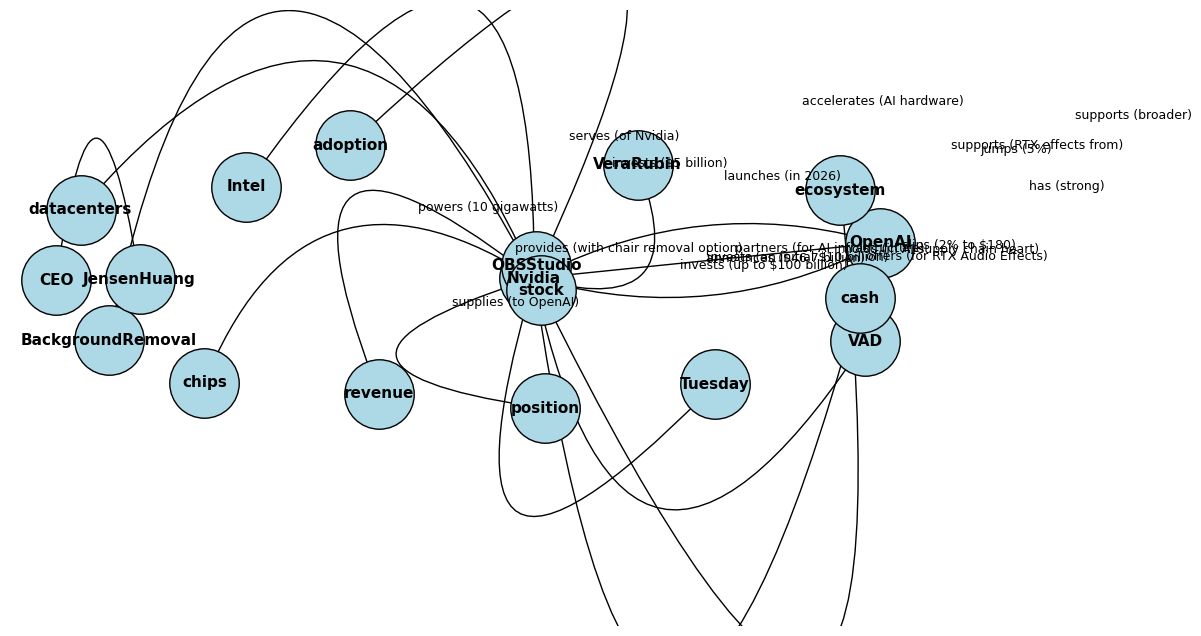

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()

for t in result['Nvidia'][6]['triplets']:
    subj, obj = t.subject, t.object
    verb, detail = t.relation.verb, t.relation.detail

    rel_label = f"{verb} ({detail})" if detail else verb

    G.add_edge(subj, obj, label=rel_label)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

for i, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    rad = 0.2 * (i - (len(G[u][v]) - 1) / 2)
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="->", arrowsize=20
    )
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x + rad*0.3, y + rad*0.3, data["label"], fontsize=9, color="black")

plt.axis("off")
plt.show()

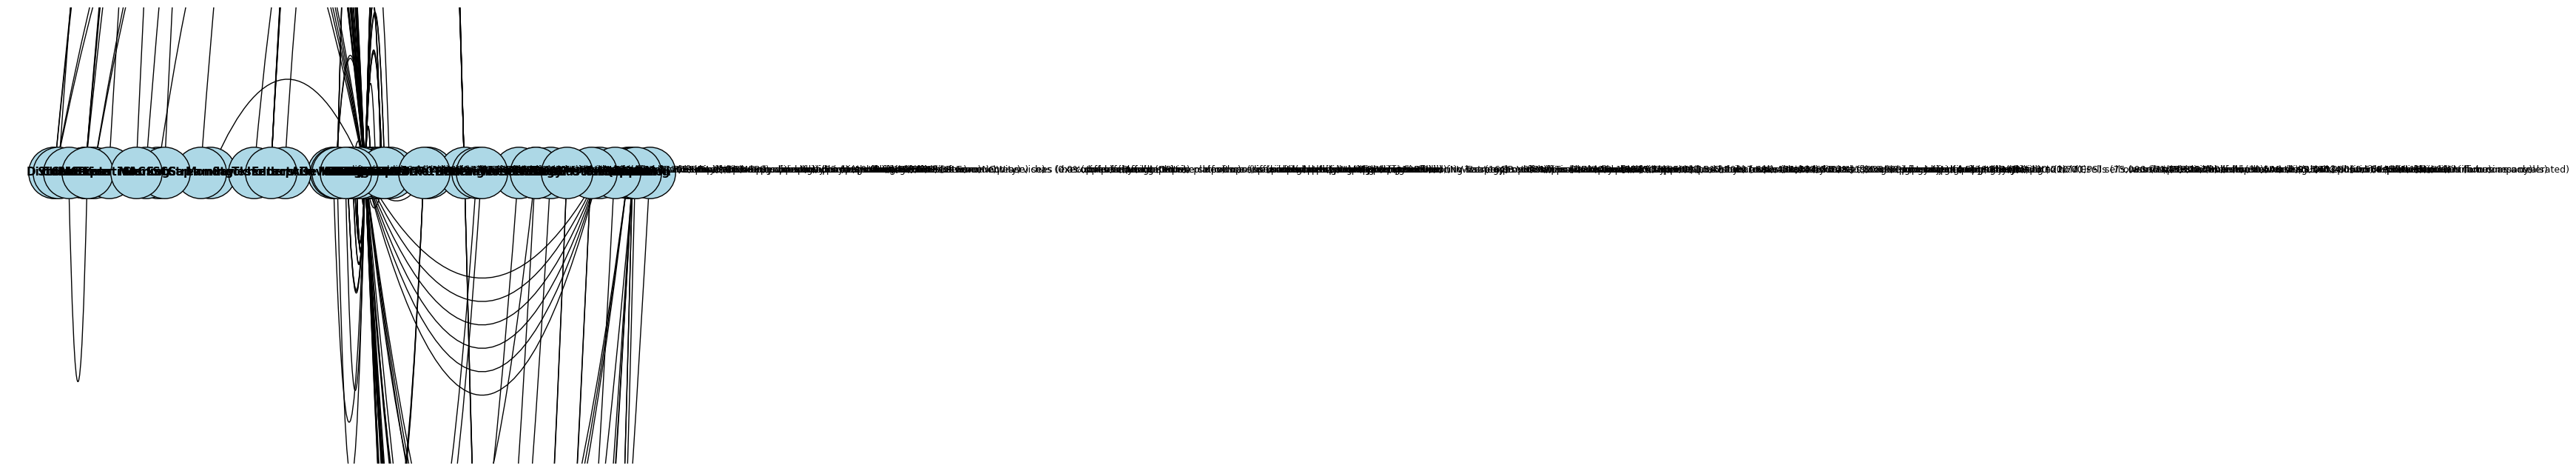

In [10]:
G = nx.MultiDiGraph()

for t in result['Nvidia'][0]['triplets']:
    subj, obj = t.subject, t.object
    verb, detail = t.relation.verb, t.relation.detail

    rel_label = f"{verb} ({detail})" if detail else verb

    G.add_edge(subj, obj, label=rel_label)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

for i, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    rad = 0.2 * (i - (len(G[u][v]) - 1) / 2)
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="->", arrowsize=20
    )
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x + rad*0.3, y + rad*0.3, data["label"], fontsize=9, color="black")

plt.axis("off")
plt.show()

In [11]:
import json

serializable_result = {
    chip: [
        {
            "date": entry["date"],
            "triplets": [
                {
                    "subject": t.subject,
                    "relation": {
                        "verb": t.relation.verb,
                        "detail": t.relation.detail
                    },
                    "object": t.object
                }
                for t in entry["triplets"]
            ]
        }
        for entry in entries
    ]
    for chip, entries in result.items()
}

with open("week3.json", mode="w", encoding="utf-8") as f:
    json.dump(serializable_result, f, ensure_ascii=False, indent=2)